In [220]:
#!pip install cvxopt

In [504]:
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt

#Seeting the number of stocks
n_pairs = 100 #5 for trying, 30 for pretty graph, 100 for the paper
n_obs_per_sieres = 3000

mu_scale = 0.5

#Drawing n_pairs pairs of mean and variance
mu1 = np.random.uniform(low=-mu_scale, high=mu_scale, size=n_pairs)
sig1 = [np.random.uniform(low=abs(mu), high=2*abs(mu)) for mu in mu1]



#Drawing random series using mean and variance
group1 = np.random.normal(mu1, sig1, size=(n_obs_per_sieres, n_pairs))
group1_p = copy.deepcopy(group1)
group1_n = copy.deepcopy(group1)
group1_n[group1_n>0]=0

#Getting the mean
group1_mu = np.mean(group1, axis=0)
group1_std = np.std(group1, axis=0)
group1_lp = -1*np.mean(group1_n, axis=0)


In [505]:
##Pairwise comparsion for the modified MV rule
# nPSD_t = []
# for k in np.arange(0, n_pairs, 1).tolist():
#     for l in np.arange(0, n_pairs, 1).tolist():
#         if (k != l) and (k not in nPSD_t) and (group1_mu[l]>group1_mu[k]) and (group1_lp[l]<=group1_lp[k]) and (group1_std[l]>group1_std[k]):
#             nPSD.append(k)
#             print(k,l)
#             print(group1_mu[k]/group1_std[k], group1_mu[l]/group1_std[l])

# returns_n = copy.deepcopy(returns)
# risks_n = copy.deepcopy(risks)
            
# #Delete dominated porfolios in PSD sense 
# for q in nPSD_t[::-1]: #To keep the order correct, we start from the end towards the first
#     del returns_n[q]
#     del risks_n[q]

#print(nPSD)

In [506]:
from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

n = n_pairs

cov = np.cov(group1.T,ddof=0) #Caculate covariance matrix is different with variance. It works on Transpose.
covm = matrix(cov)

#Return of asset
pbar = matrix(group1_mu)

#G is contraints for inequality
#h is the values of the inequality contraints
#G*x <= h
#Create nxn matrix
G = matrix(0.0, (n,n))
#a[start:stop:step] means start through not past stop, by step
G[::n+1] = -1.0 #The terms in the diagonal is -1
h = matrix(0.0, (n,1))
#  A*x = b. We have one equality contraint
A = matrix(1.0, (1,n))
b = matrix(1.0)

In [507]:
#Modifed from https://cvxopt.org/userguide/coneprog.html#quadratic-programming
import math
import time
import numpy as np

start_time = time.time()

#Example from cvxopt
# N = 100
# mus = [ 10**(5.0*t/N-1.0) for t in range(N) ]
# xs = [ qp(mu*covm, -pbar, G, h, A, b)['x'] for mu in mus ]


#Weight to objective
n_part = 100 # means n_part objectives
gamma_min = 0.0001
gamma_max = 0.9999
gamma1 = np.arange(gamma_min, gamma_max, (1-gamma_min)/n_part).tolist()


def solve_por():
    xs = []
    for c1 in gamma1:
            c3 = 1 - c1 
            xs.append(qp(c3*covm, -c1*pbar, G, h, A, b)['x']) 
            print(c1,c3)
    return xs
xs = solve_por()



#Weighted series
ws = [ group1*list(x) for x in xs ]
#Weighted returns
wr = [np.sum(s, axis=1) for s in ws]
wr_l = copy.deepcopy(wr)


# Make all positive value become zero
for k in np.arange(0, n_part, 1).tolist():
    wr_l[k][wr_l[k]>0]=0


# The expected return of the profolios
returns = [ dot(pbar,x) for x in xs ]
# The variance of the profolio
risks = [ sqrt(dot(x, covm*x)) for x in xs ]

# The lower partial moment of portofolios
low_p = [ -1*np.mean(wl, axis=0) for wl in wr_l ]


# print("--- %s seconds ---" % (time.time() - start_time))

     pcost       dcost       gap    pres   dres
 0:  7.3577e-04 -1.0008e+00  1e+00  4e-16  1e+01
 1:  7.3170e-04 -1.0787e-02  1e-02  1e-16  1e-01
 2:  5.3912e-04 -6.7434e-04  1e-03  2e-16  1e-02
 3:  1.1445e-04 -3.8637e-04  5e-04  1e-15  6e-18
 4:  4.9627e-05 -5.3030e-05  1e-04  2e-16  4e-18
 5:  1.4751e-05 -2.6855e-05  4e-05  2e-16  2e-18
 6:  2.6636e-06 -3.0544e-06  6e-06  2e-16  1e-18
 7:  2.9411e-07 -5.2367e-07  8e-07  2e-16  4e-19
 8: -6.1749e-08 -1.5251e-07  9e-08  2e-16  2e-19
Optimal solution found.
0.0001 0.9999
     pcost       dcost       gap    pres   dres
 0:  2.7576e-04 -1.0028e+00  1e+00  4e-16  1e+01
 1:  2.6467e-04 -1.2796e-02  1e-02  2e-17  1e-01
 2: -2.0321e-04 -2.1262e-03  2e-03  2e-16  2e-02
 3: -9.1753e-04 -1.5122e-03  6e-04  4e-16  1e-17
 4: -1.0839e-03 -1.1838e-03  1e-04  1e-16  1e-17
 5: -1.1232e-03 -1.1293e-03  6e-06  2e-16  1e-17
 6: -1.1264e-03 -1.1265e-03  7e-08  2e-16  8e-18
Optimal solution found.
0.010099 0.989901
     pcost       dcost       gap    pres

 6: -8.5252e-02 -8.5531e-02  3e-04  2e-16  3e-16
 7: -8.5428e-02 -8.5435e-02  7e-06  6e-17  5e-16
 8: -8.5432e-02 -8.5433e-02  5e-07  5e-17  4e-16
 9: -8.5433e-02 -8.5433e-02  4e-08  1e-16  3e-16
Optimal solution found.
0.220078 0.779922
     pcost       dcost       gap    pres   dres
 0: -3.1847e-01 -1.1189e+00  1e+02  1e+01  1e+01
 1: -2.2768e-02 -1.0673e+00  2e+00  1e-01  1e-01
 2: -1.3618e-02 -3.4293e-01  3e-01  3e-17  3e-15
 3: -3.2505e-02 -1.1027e-01  8e-02  6e-16  1e-15
 4: -7.7285e-02 -1.1854e-01  4e-02  5e-17  4e-16
 5: -8.7106e-02 -9.3586e-02  6e-03  2e-16  4e-16
 6: -8.9780e-02 -9.0077e-02  3e-04  5e-17  5e-16
 7: -8.9964e-02 -8.9972e-02  7e-06  2e-16  4e-16
 8: -8.9970e-02 -8.9970e-02  2e-07  4e-17  4e-16
 9: -8.9970e-02 -8.9970e-02  4e-09  2e-16  4e-16
Optimal solution found.
0.230077 0.769923
     pcost       dcost       gap    pres   dres
 0: -3.4814e-01 -1.1257e+00  1e+02  1e+01  1e+01
 1: -2.4878e-02 -1.0715e+00  2e+00  1e-01  1e-01
 2: -1.4747e-02 -3.5306e-01  3e-01  

     pcost       dcost       gap    pres   dres
 0: -1.3268e+00 -1.2867e+00  1e+02  1e+01  9e+00
 1: -7.9785e-02 -1.1656e+00  3e+00  2e-01  1e-01
 2: -4.5022e-02 -4.8976e-01  4e-01  8e-16  2e-15
 3: -9.3822e-02 -2.2041e-01  1e-01  1e-16  1e-15
 4: -1.6620e-01 -2.3833e-01  7e-02  5e-17  5e-16
 5: -1.8897e-01 -2.0018e-01  1e-02  4e-17  7e-16
 6: -1.9402e-01 -1.9481e-01  8e-04  1e-16  7e-16
 7: -1.9460e-01 -1.9462e-01  2e-05  7e-17  7e-16
 8: -1.9461e-01 -1.9461e-01  4e-07  2e-16  6e-16
 9: -1.9461e-01 -1.9461e-01  4e-09  4e-16  7e-16
Optimal solution found.
0.45005500000000004 0.5499449999999999
     pcost       dcost       gap    pres   dres
 0: -1.3919e+00 -1.2950e+00  1e+02  1e+01  9e+00
 1: -8.2537e-02 -1.1705e+00  3e+00  2e-01  1e-01
 2: -4.6755e-02 -4.9314e-01  4e-01  4e-17  2e-15
 3: -9.7297e-02 -2.2540e-01  1e-01  6e-16  1e-15
 4: -1.7046e-01 -2.4328e-01  7e-02  2e-16  6e-16
 5: -1.9385e-01 -2.0525e-01  1e-02  4e-16  6e-16
 6: -1.9874e-01 -2.0025e-01  2e-03  1e-16  6e-16
 7: -1.9

 3: -1.9639e-01 -3.2932e-01  1e-01  2e-16  8e-16
 4: -2.7152e-01 -3.3221e-01  6e-02  1e-16  6e-16
 5: -3.0692e-01 -3.1121e-01  4e-03  3e-16  7e-16
 6: -3.0999e-01 -3.1012e-01  1e-04  2e-16  9e-16
 7: -3.1009e-01 -3.1010e-01  3e-06  1e-16  6e-16
 8: -3.1010e-01 -3.1010e-01  4e-08  1e-16  5e-16
Optimal solution found.
0.6700330000000001 0.3299669999999999
     pcost       dcost       gap    pres   dres
 0: -3.3296e+00 -1.4651e+00  2e+02  1e+01  7e+00
 1: -1.2824e-01 -1.2845e+00  3e+00  1e-01  7e-02
 2: -9.0843e-02 -4.9940e-01  4e-01  4e-17  1e-15
 3: -2.0399e-01 -3.3417e-01  1e-01  4e-16  9e-16
 4: -2.7789e-01 -3.3554e-01  6e-02  1e-16  5e-16
 5: -3.1310e-01 -3.1628e-01  3e-03  2e-16  8e-16
 6: -3.1550e-01 -3.1559e-01  9e-05  2e-16  8e-16
 7: -3.1557e-01 -3.1558e-01  3e-06  1e-16  7e-16
 8: -3.1557e-01 -3.1558e-01  3e-07  1e-16  8e-16
Optimal solution found.
0.6800320000000001 0.3199679999999999
     pcost       dcost       gap    pres   dres
 0: -3.4432e+00 -1.4715e+00  2e+02  1e+01  7e

 5: -4.5495e-01 -4.5954e-01  5e-03  2e-16  8e-16
 6: -4.5843e-01 -4.5851e-01  8e-05  2e-16  8e-16
 7: -4.5849e-01 -4.5849e-01  1e-06  1e-16  8e-16
 8: -4.5849e-01 -4.5849e-01  1e-08  1e-16  7e-16
Optimal solution found.
0.930007 0.06999299999999997
     pcost       dcost       gap    pres   dres
 0: -7.1911e+00 -1.5333e+00  2e+02  1e+01  5e+00
 1: -1.3337e-01 -1.4417e+00  2e+00  8e-02  3e-02
 2: -1.4671e-01 -4.8530e-01  4e-01  6e-03  2e-03
 3: -2.6792e-01 -5.8248e-01  3e-01  4e-03  2e-03
 4: -4.3686e-01 -4.7312e-01  4e-02  3e-04  1e-04
 5: -4.6126e-01 -4.6588e-01  5e-03  2e-16  7e-16
 6: -4.6482e-01 -4.6488e-01  6e-05  2e-16  7e-16
 7: -4.6487e-01 -4.6487e-01  6e-07  2e-16  7e-16
 8: -4.6487e-01 -4.6487e-01  6e-09  2e-16  7e-16
Optimal solution found.
0.9400060000000001 0.05999399999999988
     pcost       dcost       gap    pres   dres
 0: -7.3829e+00 -1.5306e+00  2e+02  1e+01  5e+00
 1: -1.3409e-01 -1.4492e+00  2e+00  8e-02  3e-02
 2: -1.4851e-01 -4.9056e-01  4e-01  6e-03  2e-03
 3: 

In [508]:
# #Histogram
# plt.hist(wr[0], bins = 100)
# plt.show()

In [509]:
nPSD = []
for k in np.arange(0, n_part, 1).tolist():
    for l in np.arange(0, n_part, 1).tolist():
        if (k != l) and (k not in nPSD) and (returns[l]>returns[k]) and (low_p[l]<=low_p[k]) and (risks[l]>risks[k]):
            nPSD.append(k)

returns_n = copy.deepcopy(returns)
risks_n = copy.deepcopy(risks)
            
#Delete dominated porfolios in PSD sense 
for q in nPSD[::-1]: #To keep the order correct, we start from the end towards the first
    del returns_n[q]
    del risks_n[q]


(0.0, 0.5577531888831633)

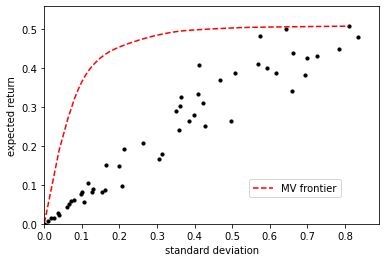

In [510]:
import pylab

# Plot trade-off curve and optimal allocations.
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns, 'r--',label='MV frontier') 
plt.scatter(group1_std, group1_mu, c ="black",s=10)
#plt.scatter(risks, returns, c ="red")
pylab.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
pylab.xlim(0, max(risks)*1.1)
pylab.ylim(0, max(returns)*1.1)
#pylab.title('Risk-return trade-off curve')

Text(0, 0.5, 'expected return')

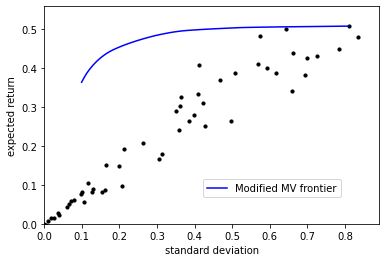

In [511]:
import pylab

# Plot trade-off curve and optimal allocations.
pylab.figure(1, facecolor='w')
# pylab.plot(risks, returns, 'r--',label='MV frontier') 
pylab.plot(risks_n, returns_n, 'b-',label='Modified MV frontier')
#Scatter to shows portofolios
#plt.scatter(risks, returns, c ="red")
#plt.scatter(risks_n, returns_n, c ="blue")


plt.scatter(group1_std, group1_mu, c ="black",s=10)
pylab.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
pylab.xlim(0, max(risks)*1.1)
pylab.ylim(0, max(returns)*1.1)
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
#pylab.title('Risk-return trade-off curve')

Text(0, 0.5, 'expected return')

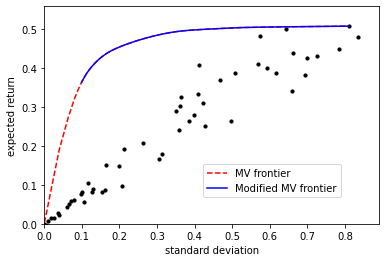

In [512]:
import pylab

# Plot trade-off curve and optimal allocations.
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns, 'r--',label='MV frontier') 
pylab.plot(risks_n, returns_n, 'b-',label='Modified MV frontier')
#Scatter to shows portofolios
#plt.scatter(risks, returns, c ="red")
#plt.scatter(risks_n, returns_n, c ="blue")


plt.scatter(group1_std, group1_mu, c ="black",s=10)
pylab.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
pylab.xlim(0, max(risks)*1.1)
pylab.ylim(0, max(returns)*1.1)
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
#pylab.title('Risk-return trade-off curve')

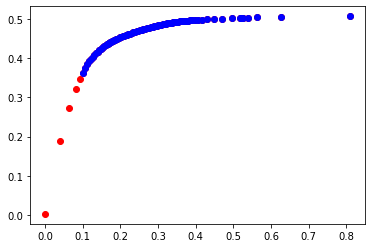

In [513]:
import matplotlib.pyplot as plt


plt.scatter(risks, returns, c ="red")
plt.scatter(risks_n, returns_n, c ="blue")
# To show the plot
plt.show()